In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("satrapankti/amazon-beauty-product-recommendation")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/satrapankti/amazon-beauty-product-recommendation/versions/1


In [2]:
#Data loading and basic information about the dataset
import pandas as pd

# Load the dataset
data = pd.read_csv('/root/.cache/kagglehub/datasets/satrapankti/amazon-beauty-product-recommendation/versions/1/Amazon_Beauty_Recommendation.csv')

# Display basic information about the dataset
print("Dataset Head:")
print(data.head())

print("\nDataset Info:")
print(data.info())

print("\nMissing Values in Each Column:")
print(data.isnull().sum())


Dataset Head:
           UserId   ProductId       ProductType  Rating   Timestamp  \
0  A3NHUQ33CFH3VM  B00LLPT4HI  Eyeliner & Kajal       5  1405814400   
1  A1TIRNQ7O4REOH  B00LLPT4HI  Eyeliner & Kajal       4  1405987200   
2  A2Y36BR4YSY9F7  B00LLPT4HI  Eyeliner & Kajal       5  1405728000   
3  A23H6FAOLEMAKC  B00LLPT4HI  Eyeliner & Kajal       5  1405814400   
4  A3CHYZGF3OO6WD  B00LLPT4HI  Eyeliner & Kajal       5  1405641600   

                                                 URL  
0  https://www.amazon.in/Maybelline-Colossal-Kaja...  
1  https://www.amazon.in/Maybelline-Colossal-Kaja...  
2  https://www.amazon.in/Maybelline-Colossal-Kaja...  
3  https://www.amazon.in/Maybelline-Colossal-Kaja...  
4  https://www.amazon.in/Maybelline-Colossal-Kaja...  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348246 entries, 0 to 1348245
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   UserId     


Updated Data Types:
UserId                 object
ProductId              object
ProductType            object
Rating                  int64
Timestamp      datetime64[ns]
URL                    object
dtype: object

Rating Distribution:
Rating
1    120305
2     75480
3    114825
4    214453
5    823183
Name: count, dtype: int64


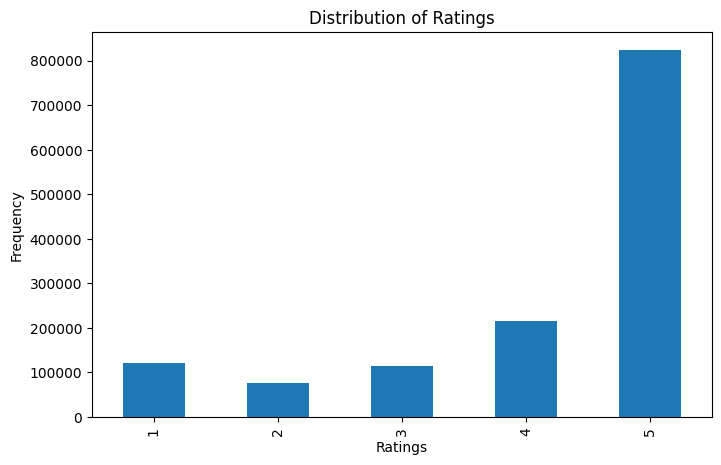

In [3]:
##Data preprocessing
# Convert Timestamp to a readable datetime format
data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='s')

# Check data types after conversion
print("\nUpdated Data Types:")
print(data.dtypes)

# Exploratory Analysis: Distribution of Ratings
rating_distribution = data['Rating'].value_counts().sort_index()

# Display the rating distribution
print("\nRating Distribution:")
print(rating_distribution)

# Plot the rating distribution (optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
rating_distribution.plot(kind='bar')
plt.title("Distribution of Ratings")
plt.xlabel("Ratings")
plt.ylabel("Frequency")
plt.show()


In [4]:
#feature engineering
from sklearn.model_selection import train_test_split

# Map UserId and ProductId to numeric IDs
user_mapping = {id: idx for idx, id in enumerate(data['UserId'].unique())}
product_mapping = {id: idx for idx, id in enumerate(data['ProductId'].unique())}

data['UserId'] = data['UserId'].map(user_mapping)
data['ProductId'] = data['ProductId'].map(product_mapping)

# Split data into training and testing sets (80-20 split)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Display the number of unique users and products in the training set
print(f"Number of unique users: {data['UserId'].nunique()}")
print(f"Number of unique products: {data['ProductId'].nunique()}")
print(f"Training set size: {train_data.shape[0]}")
print(f"Testing set size: {test_data.shape[0]}")


Number of unique users: 883753
Number of unique products: 23838
Training set size: 1078596
Testing set size: 269650


In [5]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357292 sha256=163f3f100629f6ed620ab92f200abae7ca80fb7feb3d3981408c7588f184bc12
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [6]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split as surprise_split
from surprise import accuracy

# Prepare data for Surprise
reader = Reader(rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(train_data[['UserId', 'ProductId', 'Rating']], reader)

# Train-test split for Surprise
trainset, valset = surprise_split(surprise_data, test_size=0.2, random_state=42)

# Train an SVD model
svd = SVD()
svd.fit(trainset)

# Validate the model
predictions = svd.test(valset)

# Evaluate accuracy
rmse = accuracy.rmse(predictions)
print(f"Validation RMSE: {rmse}")

# Save the SVD embeddings for users and items
user_embeddings = {uid: svd.pu[i] for i, uid in enumerate(trainset.all_users())}
item_embeddings = {iid: svd.qi[i] for i, iid in enumerate(trainset.all_items())}

print(f"Number of user embeddings: {len(user_embeddings)}")
print(f"Number of item embeddings: {len(item_embeddings)}")


RMSE: 1.2373
Validation RMSE: 1.237254800756665
Number of user embeddings: 620996
Number of item embeddings: 23838


In [7]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load pre-trained model and tokenizer
model_name = "sentence-transformers/all-MiniLM-L6-v2"  # Lightweight embedding model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Function to generate embeddings
def get_embeddings(texts, tokenizer, model):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy()

# Prepare unique ProductType values and clean data
product_types = data['ProductType'].unique()
product_types = [str(ptype) for ptype in product_types if isinstance(ptype, str) and ptype.strip()]

# Debug: Print out unique product types
print(f"Unique Product Types: {len(product_types)}")

# Generate embeddings
try:
    product_type_embeddings = get_embeddings(product_types, tokenizer, model)

    # Create a mapping from ProductType to embeddings
    product_embeddings = {ptype: emb for ptype, emb in zip(product_types, product_type_embeddings)}
    print(f"Generated embeddings for {len(product_embeddings)} product types.")
except Exception as e:
    print(f"Error generating embeddings: {e}")


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Unique Product Types: 22
Generated embeddings for 22 product types.


In [30]:
import numpy as np

# Merge embeddings: Collaborative (SVD) + Content-Based (LLM)
def merge_embeddings(item_id, svd_item_embeddings, product_type, product_embeddings):
    svd_emb = svd_item_embeddings.get(item_id, np.zeros(100))  # Default to zero vector if not found
    content_emb = product_embeddings.get(product_type, np.zeros(384))  # Adjust based on LLM embedding size
    return np.concatenate([svd_emb, content_emb])

# Create a dictionary for merged item embeddings
merged_item_embeddings = {
    item_id: merge_embeddings(
        item_id,
        item_embeddings,
        data.loc[data['ProductId'] == item_id, 'ProductType'].iloc[0],
        product_embeddings
    )
    for item_id in item_embeddings
}

print(f"Number of merged item embeddings: {len(merged_item_embeddings)}")

# Example: Generate recommendations for a sample user
def recommend(user_id, user_embeddings, merged_item_embeddings, top_k=5):
    user_emb = user_embeddings.get(user_id, np.zeros(100))  # Default to zero vector if not found
    recommendations = []
    for item_id, item_emb in merged_item_embeddings.items():
        score = np.dot(user_emb, item_emb[:100])  # Only compare collaborative dimensions
        recommendations.append((item_id, score))
    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)
    return recommendations[:top_k]

# Generate recommendations for a random user
sample_user_id = list(user_embeddings.keys())[1]
top_recommendations = recommend(sample_user_id, user_embeddings, merged_item_embeddings)

print(f"Top recommendations for user {sample_user_id}: {top_recommendations}")


Number of merged item embeddings: 23838
Top recommendations for user 1: [(682, 0.814605248311406), (434, 0.6660477690786349), (1387, 0.5985004040527091), (7329, 0.5954066570851352), (3189, 0.5653898364705976)]


In [32]:
# Reverse mapping from numeric to original UserId
reverse_user_mapping = {idx: id for id, idx in user_mapping.items()}

# Get original UserId for the sampled user
sample_user_id = list(user_embeddings.keys())[1]  # Get the second user (example)
original_user_id = reverse_user_mapping[sample_user_id]

print(f"Sampled numeric user_id: {sample_user_id}")
print(f"Original UserId for sampled user: {original_user_id}")

# Generate recommendations for the sampled user
top_recommendations = recommend(sample_user_id, user_embeddings, merged_item_embeddings)
print(f"Top recommendations for user {original_user_id}: {top_recommendations}")


Sampled numeric user_id: 1
Original UserId for sampled user: A1TIRNQ7O4REOH
Top recommendations for user A1TIRNQ7O4REOH: [(682, 0.814605248311406), (434, 0.6660477690786349), (1387, 0.5985004040527091), (7329, 0.5954066570851352), (3189, 0.5653898364705976)]


In [34]:
import pandas as pd

# Function to retrieve product details
def get_product_details(product_id, data):
    product_info = data[data['ProductId'] == product_id]
    if product_info.empty:
        # Return default values if the product ID is not found
        return {'ProductId': product_id, 'URL': None, 'ProductType': None}
    else:
        product_info = product_info.iloc[0]
        return {
            'ProductId': product_info['ProductId'],
            'URL': product_info['URL'],
            'ProductType': product_info['ProductType']
        }


# Generate recommendations with product details
def recommend_with_details(user_id, user_embeddings, merged_item_embeddings, data, top_k=5):
    user_emb = user_embeddings.get(user_id, np.zeros(100))  # Default to zero vector if not found
    recommendations = []

    for item_id, item_emb in merged_item_embeddings.items():
        score = np.dot(user_emb, item_emb[:100])  # Only compare collaborative dimensions
        recommendations.append((item_id, score))

    # Sort recommendations by score
    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)[:top_k]

    # Fetch product details for top recommendations
    detailed_recommendations = [
        {**get_product_details(item[0], data), 'Score': item[1]} for item in recommendations
    ]
    return detailed_recommendations

# Get detailed recommendations for the sample user
detailed_recommendations = recommend_with_details(sample_user_id, user_embeddings, merged_item_embeddings, data)

# Convert to DataFrame for table format
recommendations_df = pd.DataFrame(detailed_recommendations)

print(sample_user_id)
# With this code to directly display the DataFrame:
print("Detailed Recommendations Table:")
recommendations_df  # or  print(recommendations_df)

1
Detailed Recommendations Table:


,ProductId,URL,ProductType,Score
0,682,https://www.amazon.in/Maybelline-Sensational-P...,Lipstick,0.814605
1,434,https://www.amazon.in/sspa/click?ie=UTF8&spc=M...,Trimmers & Clippers,0.666048
2,1387,https://www.amazon.in/MARS-Shades-Eyeshadow-pa...,Eye Shadow & Mascara,0.598500
3,7329,https://www.amazon.in/Indica-Easy-Natural-Blac...,Hair Color & Heena,0.595407
4,3189,https://www.amazon.in/Bella-Vita-Perfumes-Frag...,Deo & Perfume,0.565390


In [10]:
import pickle

# Save collaborative embeddings
with open("user_embeddings.pkl", "wb") as user_file:
    pickle.dump(user_embeddings, user_file)

with open("item_embeddings.pkl", "wb") as item_file:
    pickle.dump(item_embeddings, item_file)

# Save content-based embeddings
with open("product_embeddings.pkl", "wb") as product_file:
    pickle.dump(product_embeddings, product_file)

# Save merged item embeddings
with open("merged_item_embeddings.pkl", "wb") as merged_file:
    pickle.dump(merged_item_embeddings, merged_file)

print("Model components saved successfully!")


Model components saved successfully!


In [11]:
# Load embeddings
with open("user_embeddings.pkl", "rb") as user_file:
    user_embeddings = pickle.load(user_file)

with open("item_embeddings.pkl", "rb") as item_file:
    item_embeddings = pickle.load(item_file)

with open("product_embeddings.pkl", "rb") as product_file:
    product_embeddings = pickle.load(product_file)

with open("merged_item_embeddings.pkl", "rb") as merged_file:
    merged_item_embeddings = pickle.load(merged_file)

print("Model components loaded successfully!")


Model components loaded successfully!


In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_rating_predictions(test_data, user_embeddings, merged_item_embeddings):
    actual_ratings = []
    predicted_ratings = []

    for _, row in test_data.iterrows():
        user_id = row['UserId']
        item_id = row['ProductId']
        actual_ratings.append(row['Rating'])

        # Predict rating as dot product of user and item embeddings
        user_emb = user_embeddings.get(user_id, np.zeros(100))
        item_emb = merged_item_embeddings.get(item_id, np.zeros(484))[:100]  # Use collaborative dimensions
        predicted_ratings.append(np.dot(user_emb, item_emb))

    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
    mae = mean_absolute_error(actual_ratings, predicted_ratings)

    return rmse, mae

# Evaluate the model
rmse, mae = evaluate_rating_predictions(test_data, user_embeddings, merged_item_embeddings)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")


RMSE: 4.347712859638731
MAE: 4.145600968850442


In [20]:
def merge_embeddings_weighted(item_id, svd_item_embeddings, product_type, product_embeddings, alpha=0.5):
    """
    Merges embeddings with a weighted combination of collaborative and content-based embeddings.
    Alpha determines the weight for collaborative embeddings.
    """
    svd_emb = svd_item_embeddings.get(item_id, np.zeros(100))  # Collaborative
    content_emb = product_embeddings.get(product_type, np.zeros(384))  # Content-based
    return np.concatenate([alpha * svd_emb, (1 - alpha) * content_emb])

# Adjust weights and recompute merged item embeddings
alpha = 0.7  # Assign more weight to collaborative filtering
merged_item_embeddings_refined = {
    item_id: merge_embeddings_weighted(
        item_id,
        item_embeddings,
        data.loc[data['ProductId'] == item_id, 'ProductType'].iloc[0],
        product_embeddings,
        alpha=alpha
    )
    for item_id in item_embeddings
}
print("Refined merged embeddings created.")


Refined merged embeddings created.


In [21]:
# Calculate product popularity (average rating and count)
product_popularity = (
    data.groupby('ProductId')
    .agg({'Rating': ['mean', 'count']})
    .reset_index()
)
product_popularity.columns = ['ProductId', 'AvgRating', 'RatingCount']

# Filter for popular products
popular_products = product_popularity[product_popularity['RatingCount'] > 10]  # Adjust threshold as needed
popular_product_ids = set(popular_products['ProductId'])

# Refine recommendations to include only popular products
def recommend_popular(user_id, user_embeddings, merged_item_embeddings, top_k=10):
    recommendations = recommend(user_id, user_embeddings, merged_item_embeddings, top_k=top_k * 2)  # Generate more
    filtered_recommendations = [
        rec for rec in recommendations if rec[0] in popular_product_ids
    ]
    return filtered_recommendations[:top_k]

# Example usage
refined_recommendations = recommend_popular(sample_user_id, user_embeddings, merged_item_embeddings_refined)
print("Refined recommendations generated.")


Refined recommendations generated.


In [22]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split as surprise_split
from surprise import accuracy

# Step 1: Add a recency weight to interactions based on the timestamp
def calculate_interaction_weight(timestamp, max_timestamp, scale=30):
    """
    Calculate interaction weight based on recency.
    More recent interactions get higher weights.
    """
    return 1 / (1 + np.exp((max_timestamp - timestamp).days / scale))

# Convert Timestamp to datetime if not already done
if not np.issubdtype(data['Timestamp'].dtype, np.datetime64):
    data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='s')

# Get the maximum timestamp (latest interaction)
max_timestamp = data['Timestamp'].max()

# Calculate interaction weights
data['InteractionWeight'] = data['Timestamp'].apply(
    lambda ts: calculate_interaction_weight(ts, max_timestamp)
)

# Debug: Check InteractionWeight distribution
print(data[['UserId', 'ProductId', 'Timestamp', 'InteractionWeight']].head())

# Step 2: Prepare the data for SVD training with interaction weights
# Multiply ratings by interaction weights to prioritize recent interactions
data['WeightedRating'] = data['Rating'] * data['InteractionWeight']

# Prepare the dataset for Surprise
reader = Reader(rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(data[['UserId', 'ProductId', 'WeightedRating']], reader)

# Step 3: Train-Test Split
trainset, valset = surprise_split(surprise_data, test_size=0.2, random_state=42)

# Step 4: Train the SVD Model
svd = SVD()
svd.fit(trainset)

# Step 5: Validate the Model
predictions = svd.test(valset)

# Calculate RMSE and MAE
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print(f"RMSE after incorporating interaction weights: {rmse}")
print(f"MAE after incorporating interaction weights: {mae}")

# Step 6: Save User and Item Embeddings
user_embeddings_weighted = {uid: svd.pu[i] for i, uid in enumerate(trainset.all_users())}
item_embeddings_weighted = {iid: svd.qi[i] for i, iid in enumerate(trainset.all_items())}

print("Optimized user and item embeddings saved.")


   UserId  ProductId  Timestamp  InteractionWeight
0       0          0 2014-07-20           0.475021
1       1          0 2014-07-22           0.491667
2       2          0 2014-07-19           0.466716
3       3          0 2014-07-20           0.475021
4       4          0 2014-07-18           0.458430
RMSE: 0.9515
MAE:  0.9332
RMSE after incorporating interaction weights: 0.9515390035619196
MAE after incorporating interaction weights: 0.933165023581478
Optimized user and item embeddings saved.


In [33]:
import pandas as pd

def recommend_diverse(user_id, user_embeddings, merged_item_embeddings, data, top_k=10):
    """
    Generates diverse recommendations for a user by ensuring items of different types.
    Includes ProductId, ProductType, URL, and Score in the output.
    """
    # Generate initial recommendations (Top-K * 2 for diversity)
    recommendations = recommend(user_id, user_embeddings, merged_item_embeddings, top_k=top_k * 2)
    recommended_items = []
    recommended_types = set()

    for item_id, score in recommendations:
        # Get the product type and URL
        product_info = data.loc[data['ProductId'] == item_id].iloc[0]
        product_type = product_info['ProductType']
        url = product_info['URL']

        # Ensure diversity by limiting to one item per product type
        if product_type not in recommended_types:
            recommended_items.append({
                'ProductId': item_id,
                'ProductType': product_type,
                'URL': url,
                'Score': score
            })
            recommended_types.add(product_type)

        # Stop if we've reached the desired Top-K
        if len(recommended_items) == top_k:
            break

    return recommended_items

# Generate diverse recommendations
diverse_recommendations = recommend_diverse(sample_user_id, user_embeddings, merged_item_embeddings_refined, data)

# Convert to DataFrame for table display
diverse_recommendations_df = pd.DataFrame(diverse_recommendations)

# Display recommendations in table format
print(original_user_id)
print("Diverse Recommendations Table:")

diverse_recommendations_df  # or  print(diverse_recommendations_df)

A1TIRNQ7O4REOH
Diverse Recommendations Table:


,ProductId,ProductType,URL,Score
0,682,Lipstick,https://www.amazon.in/Maybelline-Sensational-P...,0.570224
1,434,Trimmers & Clippers,https://www.amazon.in/sspa/click?ie=UTF8&spc=M...,0.466233
2,1387,Eye Shadow & Mascara,https://www.amazon.in/MARS-Shades-Eyeshadow-pa...,0.418950
3,7329,Hair Color & Heena,https://www.amazon.in/Indica-Easy-Natural-Blac...,0.416785
4,3189,Deo & Perfume,https://www.amazon.in/Bella-Vita-Perfumes-Frag...,0.395773
5,1,Eyeliner & Kajal,https://www.amazon.in/Maybelline-York-Colossal...,0.392704
6,7720,Sunscreen,https://www.amazon.in/Lakme-Expert-Fairness-Su...,0.381402
7,997,Body Scrubs,https://www.amazon.in/Flynovate-Exfoliating-Gl...,0.374770
8,155,Bath Salts,https://www.amazon.in/gp/slredirect/picassoRed...,0.372933
9,5752,Face Serum,https://www.amazon.in/Minimalist-Retinol-Serum...,0.366877
